In [0]:
import heapq
from collections import defaultdict
import random
import numpy as np
import matplotlib.pyplot as plt

In [0]:
class Passenger():
  def __init__(self, collect_floor, drop_floor, arrival_time_at_elevator):
    self.collect_floor = collect_floor
    self.drop_floor = drop_floor
    self.arrival_time_at_elevator = arrival_time_at_elevator
  
  @property
  def direction(self):
    '''
    PROPERTY: calculates and returns the direction the passengers wishes
    to travel: +1 for up, -1 for down. This convention is kept throughout
    the program.
    '''
    delta = self.drop_floor - self.collect_floor 
    return int(delta/abs(delta))
  
  @property
  def distance_travelled(self):
    '''
    PROPERTY: calculates the absolute number of floors the passenger
    wishes to travel. Used to scale the journey time metric.
    '''
    return abs(self.drop_floor - self.collect_floor)
  
  def collected(self, time):
    '''
    EXTERNAL: called when passenger is collected by the elevator, records
    the time of collection.
    '''
    self.collected_at = time
    
  def dropped(self, time):
    '''
    EXTERNAL: called when passenger is dropped at the destination by the
    elevator, records the time of drop off.
    '''
    self.dropped_at = time
  
  def collect_request(self):
    return (self.collect_floor, self.direction)
  
  def waiting_time(self):
    '''
    EXTERNAL: returns the total time the passenger waited for the elevator
    from their arrival at the elevator to their collection.
    '''
    return (self.collected_at - self.arrival_time_at_elevator)
  
  def time_per_floor(self):
    '''
    EXTERNAL: returns the total time the passenger was in the elevator
    from their collection by the elevator to their drop off scaled by
    the distance they travelled.
    '''
    return (self.dropped_at - self.collected_at)/self.distance_travelled
    
  def __lt__(self, other):
    # The heap used to store waiting passengers uses the lt method on the
    # object to break priority ties. We are agnostic to ordering of passengers
    # of the same priority. Ergo, return True regardless.
    return True
  
  def __str__(self):
    # Useful representation of the passenger object.
    return "Passenger(collect={} drop={} arrive={})".format(
        self.collect_floor, self.drop_floor, self.arrival_time_at_elevator)
  
  def __repr__(self):
    return str(self)
 
    

In [0]:
class Building():

  def __init__(self, verbose, elevator_class, config):
    # DEBUG: boolean flag used to turn on state print out.
    self.verbose = verbose
    
    # Build elevator.
    self.elevator = elevator_class(
        self, capacity=config.ELEVATOR_CAPACITY,
        verbose=verbose)
    
    # Config constants.
    self.NUM_FLOORS = config.BUILDING_FLOORS
    self.LAST_PASSENGER_ARRIVAL = config.LAST_ARRIVAL
    self.NUM_PASSENGERS = config.NUM_PASSENGERS
    
    # Passenger state.
    
    # Pending passengers are those who haven't yet arrived at the elevator.
    self.pending_passengers = defaultdict(list)
    
    # Waiting passengers have arrived and called the elevator,
    # they are awaiting collection.
    self.waiting_passengers = defaultdict(list)
    
    # Arrived passengers are at their destination.
    self.arrived_passengers = []
    
    self._create_passengers()
    
    # Time state
    self.time_in_steps = 0
  
  def _get_random_floor(self):
    '''
    RETURNS: a random floor in the building according
    to a specified distribution. In this case, the distribution
    is uniform. This encodes a strong and unrealistic assumption
    that journeys are likely to start and end on any floor with equal
    probability (although they cannot start/end on the same floor).
    
    This could easily be changed by encoding a more complex distribution
    into this function, perhaps taking a collect/drop parameter to change
    the distribution for the start/end of journeys.
    '''
    return random.randint(0, self.NUM_FLOORS)
  
  def _create_passengers(self):
    '''
    INTERNAL: building NUM_PASSENGERS passengers with random journeys
    between floors. Stores them for later processing by elevator.
    '''
    
    # Loop to generate each passenger up to NUM_PASSENGERS
    for _ in range(self.NUM_PASSENGERS):
      
      # Get random collect and drop floors.
      collect_floor = self._get_random_floor()
      
      # Ensure the randomly selected drop floor
      # is different to the collect floor. First, assign collect to drop,
      # then loop until different. This should happen almost immediately.
      drop_floor = collect_floor
      while drop_floor == collect_floor:
        drop_floor = self._get_random_floor()
      
      # Get a random time for arrival at the elevator.
      arrival_time_at_elevator = random.randint(0, self.LAST_PASSENGER_ARRIVAL)
      
      # Build the passenger and add them to the internal storage.
      passenger = Passenger(collect_floor, drop_floor, arrival_time_at_elevator)
      
      # Passengers are stored in a heap per floor, sorted by arrival time.
      # This allows O(1) access to the next arriving passengers at a floor.
      # The heap could be avoided by generating passengers in order of arrival
      # with a random waiting time. That strategy isn't pursued here.
      heapq.heappush(self.pending_passengers[collect_floor],
                     (passenger.arrival_time_at_elevator, passenger))
  
  def check_for_new_arrived_passengers(self):
    '''
    INTERNAL: this function loops through all floors in the building and
    checks if the passenger/s 'at the top' of the pending heap have arrived.
    If they have, they are moved to the waiting passengers list and
    the elevator is notified of a call. This prevents the elevator
    from being 'omniscient'. It only knows of arrived passengers.
    '''
    for floor in range(self.NUM_FLOORS + 1):
      # Loop until the passenger with the smallest arrival time is greater
      # than the given time. Recall that negative arrival_time_at_elevator
      # is the heap key such that negative heap key is the arrival time.
      while (len(self.pending_passengers[floor]) > 0 and
           self.pending_passengers[floor][0][0] <= self.time_in_steps):
        
        # Remove passenger from pending and add to the waiting
        # queue.
        _, passenger = heapq.heappop(self.pending_passengers[floor])
        self.waiting_passengers[floor].append(passenger)
        
        # Notify elevator of call from passenger.
        self.elevator.receive_collect_request(
            request=passenger.collect_request())
      
  
  def get_passengers_at_floor(self, floor, capacity):
    '''
    EXTERNAL: Elevator interface method, used by the elevator to collect
    passengers from their collect floor in the building. This method
    is also responsible for updating passengers to facillitate state tracking.
    
    RETURNS: all the passengers at a given floor, who have arrived
    at the elevator by the 'time' given. Only a number of passengers
    specified by 'capacity' are returned. 
    '''
    
    # Get all the passengers waiting at the floor who fit into
    # the supplied capacity. These are the passengers who will be collected.
    passengers_to_collect = self.waiting_passengers[floor][:capacity]
    
    # Notify these passengers of collection.
    for passenger in passengers_to_collect:
      passenger.collected(time=self.time_in_steps)
    
    # Update waiting passengers to remove those just collected.
    self.waiting_passengers[floor] = self.waiting_passengers[floor][capacity:]
    
    return passengers_to_collect
  
  def drop_passenger_at_floor(self, passenger):
    '''
    EXTERNAL: Elevator interface method, used by the elevator to drop
    passengers at their destination floor in the building. This method
    is also responsible for updating passengers to facillitate state tracking.
    '''
    # Notify passenger of the drop.
    passenger.dropped(time=self.time_in_steps)
    
    # Add to arrived passengers.
    self.arrived_passengers.append(passenger)
    
    # DEBUG: print state to notify of arrival.
    if self.verbose:
      print("Person arrived at time", self.time_in_steps)
      print(len(self.arrived_passengers), "of", self.NUM_PASSENGERS,
           "have arrived\n")
    
  def run(self):
    '''
    MAIN: this method runs the simulation, looping until all passengers
    have arrived at their destination floor (they appear in arrived passengers)
    '''
    while len(self.arrived_passengers) < self.NUM_PASSENGERS:
      self.check_for_new_arrived_passengers() # Advance building state.
      self.elevator.step() # Advance elevator state.
      self.time_in_steps += 1

In [0]:
class BasicElevator():
  STOPPED_STATE = "stopped"
  MOVING_STATE = "moving"
  
  def __init__(self, building, capacity, verbose=False):
    # DEBUG
    self.verbose = verbose
    
    # Store ref to building to collect passengers.
    self.building = building
    
    ### configuration constants
    self.CAPACITY = capacity
    
    # Elevator state is made up of three pieces of information
    # the current motion state (stopped/moving), the floor
    # and the direction of travel.
    self.state = self.STOPPED_STATE
    self.current_floor = 0
    
     # +1 for up, -1 for down. Start down, as if just arrived in the lobby.
    self.direction = 1 
    
    # List of passengers in the elevator
    self.passengers = []
    
    # List of requests for collections.
    # Each time a passenger arrives at the elevator doors
    # a collect request is sent to the elevator by the building.
    self.collect_requests = []
  
    # Metrics
    
    # Energy consumption counted in number of moves
    # between two floors. Assumption, moving up/down 
    # uses roughly the same energy. No penalty for stopping/starting.
    # These assumptions are fairly unrealistic.
    self.energy_used = 0 
    
    # The number of steps at which the elevator is at full capacity.
    self.steps_at_capacity = 0
  
  @property
  def free_capacity(self):
    '''
    RETURNS: the number of spaces available in the elevator.
    '''
    return self.CAPACITY - len(self.passengers)
  
  @property
  def passenger_collect_floors(self):
    '''
    RETURNS a list of floors where passengers are waiting for collection.
    '''
    return [request[0] for request in self.collect_requests]
  
  @property
  def passenger_destination_floors(self):
    '''
    RETURNS a list of floors where passengers currently in the elevator need
    to be dropped off.
    '''
    return [passenger.drop_floor for passenger in self.passengers]
  
  ### EXTERNAL INTERFACE
  
  def receive_collect_request(self, request):
    '''
    EXTERNAL: receive a new passenger collect request from the building.
    A request has two pieces of information, which floor the passenger
    is on and which direction they'd like to travel in. It is reasonable
    to assume this is the information which would be available to a simple
    real-world elevator.
    
    Note that this information is simple enough that we simply store it in
    a tuple. The tuple fully identifies the request, there is no value
    in uniqueness of the entity of a specific request.
    '''
    self.collect_requests.append(request)
  
  ### MOVEMENT PLANNING AND EXECUTION
  
  # The methods below implement the movement strategy. The basic pattern
  # is as follows: at each time step, the methods _should_move and _should_stop
  # decide if the elevator should take the respective action. _execute_move
  # and _execute_stop implement what a move and stop should actually look like.
  # The step method then uses these methods to run the elevator for one
  # time step.
  
  def _should_move(self):
    '''
    INTERNAL: this method decides, based on internal state,
    whether the elevator should move at the current time step.
    
    In this basic elevator, the elevator stops at every floor, so 
    it moves if it just stopped and stops if it just moved. This is
    implemented below.
    '''
    return self.state == self.STOPPED_STATE
  
  def _should_stop(self):
    '''
    INTERNAL: this method decides, based on internal state, if the
    elevator should stop at the current time step.
    
    See the method above for explanation of the specific implementation below
    for he basic elevator.
    '''
    return self.state == self.MOVING_STATE
  
  def _decide_direction(self):
    '''
    INTERNAL: sets direction of elevator based on internal state.
    
    In the basic elevator, we continue to go up until we reach the top
    and then turn around. Doing the same at the bottom.
    '''
    
    # Change direction if at top or bottom of building.
    if self.current_floor == self.building.NUM_FLOORS:
      self.direction = -1
    elif self.current_floor == 0:
      self.direction = 1
      
  def _execute_move(self):
    '''
    INTERNAL: this method implements an actual movement. In/decrementing the
    current_floor based on the direction of travel. It also tracks the energy
    used by the elevator.
    '''
    
    # Move one floor in the direction of travel
    # and increment energy used.
    self.current_floor += self.direction
    self.energy_used += 1
    
  def _execute_stop(self):
    '''
    INTERNAL: this methods implements the logic for a stop
    at a floor. This involves incrementing the time appropriately
    and collect/offloading passengers.
    '''
    
    # Offload any passengers who are at their destination. It is important
    # to do this first so that the new capacity released by the drop offs
    # is taken into account during the collection below.
    for passenger in self.passengers:
      if self.current_floor == passenger.drop_floor:
        self.passengers.remove(passenger)  # remove from elevator
        
        # Send passenger back to building.
        self.building.drop_passenger_at_floor(passenger)
    
    # Collect the passengers who are waiting at the floor.
    # First get passengers from building.
    new_passengers = self.building.get_passengers_at_floor(
        self.current_floor, self.free_capacity)
    
    # Add new passengers to internal state
    for passenger in new_passengers:
      # Add the passenger to the internal list of passengers
      self.passengers.append(passenger)
      
      # Remove a matching collect request because the passenger
      # is now collected. The exact request removed is irrelevant in
      # this implementation (requests with matching data are homogenous).
      self.collect_requests.remove(passenger.collect_request())
      
  def step(self):
    
    # DEBUG: print state and plans prior to update.
    if self.verbose:
      print("floor", self.current_floor, "dir", self.direction)
      print("State", self.state,
            "will move?", self._should_move(),
            "will stop?", self._should_stop())
      print("collect_requests", self.collect_requests)
      print("passenger destinations", self.passenger_destination_floors)
      print()
    
    # First choose a direction to move.
    self._decide_direction()
    
    # Next, execute either a move or a stop.
    if self._should_move():
      self._execute_move()  # update state.
      self.state = self.MOVING_STATE  # record new state.
    elif self._should_stop():
      self._execute_stop()  # update state.
      self.state = self.STOPPED_STATE  # record new state.
      
    # Metric updates
    if self.free_capacity == 0:
      self.steps_at_capacity += 1
      
class Strategy2Elevator(BasicElevator):
  '''
  Strategy #2: This elevator extends the basic elevator and implements
  a smarter movement strategy. It only stops if there are people to collect
  on a floor and it has capacity to collect at least one person or if there
  are people in the elevator who need to be dropped at a floor.
  
  The elevator still proceeds up and down the building from bottom to top
  and top to bottom.
  '''
  
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
   
  def can_collect_at_floor(self):
    '''
    RETURNS whether the elevator can collect passengers at the current floor
    based on capacity and whether there are collect requests at the floor.
    '''
    return (self.free_capacity > 0 and
            self.current_floor in self.passenger_collect_floors)
  
  def can_drop_at_floor(self):
    '''
    RETURNS whether the elevator can drop passengers at the current floor
    based whether there are passengers with a matching destination floor.
    '''
    return self.current_floor in self.passenger_destination_floors
  
  ### STRATEGY OVERRIDES: we override the should stop and should move methods
  # to implement the smarter strategy.
  
  def _should_stop(self):
    '''
    The elevator should stop if it is moving and it can either collect 
    or drop passengers at the current floor.
    
    Note that the planning here is simple but effective:
    if passengers can be dropped at a floor, the elevator will always stop,
    which means even if capacity is zero and initially can_collect_at_floor is
    false, passengers may still be collected during the stop by the 
    execute stop method. The loose coupling of methods makes up for the lack
    of contigent planning.
    '''
    
    return (self.state == self.MOVING_STATE and 
            (self.can_collect_at_floor() or self.can_drop_at_floor()))
  
  def _should_move(self):
    '''
    The elevator should move in one of two conditions. Either, it just stopped
    or it should not stop (in which case two moves will occur in a row as
    a floor is skipped.)
    '''
    return (not self._should_stop()) or self.state == self.STOPPED_STATE
  
class Strategy3Elevator(Strategy2Elevator):
  '''
  Strategy #3: This elevator extends the Strategy #2 elevator and implements
  a smarter collection strategy. It only collects passengers who are heading
  in the same direction as the current motion of the elevator. This should
  serve to shorten the journey time of passengers (possibly at the expense
  of longer waiting time) by avoiding situations where they move in the wrong
  direction before moving in the right direction.
  
  The elevator still proceeds up and down the building from bottom to top
  and top to bottom.
  '''
  
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    
    self.reset_direction = False
    
  def can_collect_at_floor(self):
    '''
    Instead of checking for a matching between the current floor and 
    the passenger collection request floors, we now check for a match
    in floor and direction of travel. This should shorten the journey time
    by avoiding picking people up when we are moving away from their destination.
    '''
    
    return (self.free_capacity > 0 and
            (self.current_floor, self.direction) in self.collect_requests)
  
class Strategy4Elevator(Strategy3Elevator):
  '''
  Strategy #4: This elevator extends the Strategy #3 elevator and implements
  a smarter navigation strategy, moving away from the bottom to top
  shuttle service. Further, to save energy, it only moves if there are 
  passengers to serve - holding in position if there are no passengers 
  to collect/drop.
  
  When a request for collection arrives, it sets direction to move directly
  to the passenger and, when they are collected, it moves in the correct
  direction to drop them off directly. While serving a passenger, it will
  collect and drop other passengers provided the direction of travel is
  consistent as was the case for strategy #3.
  '''
  
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
  
  def can_collect_at_floor(self):
    '''
    If there are passengers in the elevator,
    then only collect passengers on a floor if there direction matches
    the current direction of travel. Else, use the floor-only matcher from
    the parent class. This pre-empts the ability to change direction impl
    '''
    
    if len(self.passengers) > 0:
      return (self.free_capacity > 0 and
              (self.current_floor, self.direction) in self.collect_requests)
    else:
      return (self.free_capacity > 0 and
            self.current_floor in self.passenger_collect_floors)
    
  def _decide_direction(self):
    '''
    INTERNAL: decide on a direction of travel. If a reset of direction
    is requested (determined below) then calculate a new direction to target
    the first (new) passenger collect request. Apply the super method
    to turn around at the top and bottom as normal.
    '''
    if self.reset_direction:
      self.reset_direction = False
      if len(self.collect_requests) > 0:
        # Find the delta between the passenger collect floor and elevator.
        # Set the direction to close this delta assuming it is not zero already.
        delta = self.collect_requests[0][0] - self.current_floor
        if delta != 0:
          self.direction = int(delta/abs(delta))

        # If the delta is zero, change direction to match the direction the
        # passenger will travel after collection.
        else:
          self.direction = self.collect_requests[0][1]
    
    # Call the super method, all this does is force a direction
    # change at the top and bottom of the building. This is always required.
    super()._decide_direction()
    
  def _should_move(self):
    '''
    INTERNAL: implements the new strategy of holding in place and then
    navigating directly to a new call when one arrives.
    '''
    # Only move if there are passengers to serve. This holds the elevator
    # in place if there are no passengers in the elevator or building.
    passengers_to_serve = (len(self.collect_requests) > 0 or
                           len(self.passengers) > 0)
    
    # If there is a new request and no passengers then allow a direction
    # reset so the elevator travels straight to the new request. This
    # reset is executed by the decide_direction function above.
    if len(self.collect_requests) > 0 and len(self.passengers) == 0:
      self.reset_direction = True
    
    return passengers_to_serve and super()._should_move()

In [0]:
class Config():
  '''
  This class stores the system-wide configuration variables. It provides
  a central place to set all variables of interest, validate
  user-input and pass the values between all other objects.
  '''
  def __init__(self,
               elevator_capacity,
               building_floors,
               last_arrival,
               num_passengers):
    self.ELEVATOR_CAPACITY = elevator_capacity
    self.BUILDING_FLOORS = building_floors
    self.LAST_ARRIVAL = last_arrival
    self.NUM_PASSENGERS = num_passengers
    
    self._validate()
    
    
  def _validate(self):
    '''
    Ensure that user supplied inputs are valid. Raise helpful and
    entertaining errors if not.
    '''
    if self.ELEVATOR_CAPACITY < 1:
      raise Exception("Capacity invalid. What is this, an elevator for ants?")
      
    if 0 <= self.BUILDING_FLOORS < 2:
      raise Exception("Building floors invalid. Use the stairs!")
    elif self.BUILDING_FLOORS < 0:
      raise Exception("Building floors invalid. Foundational mistake")
      
    if self.LAST_ARRIVAL < 1:
      raise Exception ("Last arrival invalid. Negative time is reserved for Einstein")
      

In [0]:
class Experimenter():
  '''
  This class implements basic Monte Carlo simulation code. It
  runs each elevator strategy a given number of times with a supplied
  config. It stores and aggregates the various metrics from each iterations
  and provides utilities to display these metrics for consumption by the user.
  '''
  
  ELEVATOR_CLASSES = {
      "Basic Shuttle": BasicElevator,
      "Floor-based Stop": Strategy2Elevator,
      "Direction-based Stop": Strategy3Elevator,
      "Smart Navigation": Strategy4Elevator
  }
  
  METRICS = [
      "waiting_time",
      "time_per_floor",
      "travel_time",
      "energy",
      "percent_time_full",
      "total_time"
  ]
  
  def __init__(self, config, num_repeats):
    self.config = config
    self.data = defaultdict(lambda: defaultdict(list))
    self.num_repeats = num_repeats
    
  def run(self):
    """
    EXTERNAL: run the building simulation, with the given config,
    multiple times for each elevator type.
    """
    for elevator_type in self.ELEVATOR_CLASSES:
      for i in range(self.num_repeats):
        self._run_sim(elevator_type, seed=i)
        
  def display_results(self):
    for elevator_type in self.ELEVATOR_CLASSES:
      print("===================================================")
      print("Elevator type:", elevator_type, "\n")
      print("{:18}| {:8} | {:8} | {:8}".format(
          "field", "mean", "std", "99th %   |"))
      print("___________________________________________________")
      for field in self.METRICS:
        mean_val = round(np.mean(self.data[elevator_type][field+"_mean"]), 2)
        std_val = round(np.mean(self.data[elevator_type][field+"_std"]), 2)
        extreme_val = round(np.mean(self.data[elevator_type][field+"_99"]), 2)
        print("{:18}| {:8.2f} | {:8.2f} | {:8.2f} |".format(
            field, mean_val, std_val, extreme_val))
      
      print("===================================================\n")
      
  def _calculate_passenger_metric(self, elevator_type, field_name, field_data):
    self.data[elevator_type][f"{field_name}_mean"].append(np.mean(field_data))
    self.data[elevator_type][f"{field_name}_std"].append(np.std(field_data))
    self.data[elevator_type][f"{field_name}_99"].append(np.percentile(
        field_data, 99))
    
  def _persist_elevator_metric(self, elevator_type, field_name, field_val):
    self.data[elevator_type][f"{field_name}_mean"].append(field_val)
    self.data[elevator_type][f"{field_name}_std"].append(0)
    self.data[elevator_type][f"{field_name}_99"].append(field_val)
  
  def _run_sim(self, elevator_type, seed):
    '''
    Run a single simulation of the building with a given config
    and elevator type. Save the results. Use a supplied seed to ensure
    random distributions are the same across elevator types if desired.
    '''
    random.seed(seed)
    
    # Run building simulation
    elevator_class = self.ELEVATOR_CLASSES[elevator_type]
    building = Building(
        elevator_class=elevator_class,
        config=self.config,
        verbose=False)
    
    building.run()
    
    # Extract Stats from passengers
    
    # Wait time in ticks.
    waiting_times = np.array(
        [p.waiting_time() for p in building.arrived_passengers])
    
    # Journey time in ticks per floor.
    times_per_floor = np.array(
        [p.time_per_floor() for p in building.arrived_passengers])
    
    # Distances travelled.
    distances = np.array(
        [p.distance_travelled for p in building.arrived_passengers])
    
    # For total time, standardize units and add.
    total_times = times_per_floor*distances + waiting_times
    
    # Save stats
    self._calculate_passenger_metric(elevator_type, "waiting_time", waiting_times)
    self._calculate_passenger_metric(elevator_type, "time_per_floor", times_per_floor)
    self._calculate_passenger_metric(elevator_type, "travel_time", total_times)
    
    self._persist_elevator_metric(
        elevator_type, "energy", building.elevator.energy_used)
    self._persist_elevator_metric(
        elevator_type, "percent_time_full",
        100*building.elevator.steps_at_capacity/building.time_in_steps)
    self._persist_elevator_metric(
        elevator_type, "total_time", building.time_in_steps)
    

## Basic Benchmarks

50 runs of a 50 story building, busy and quiet.

In [0]:
# Building busy, 200 people arrive over roughly 18 mins
config = Config(elevator_capacity=10,
               building_floors=50,
               last_arrival=1000,
               num_passengers=200)

e = Experimenter(config, num_repeats=50)
e.run()
e.display_results()

Elevator type: Basic Shuttle 

field             | mean     | std      | 99th %   |
___________________________________________________
waiting_time      |   287.46 |   263.61 |  1030.37 |
time_per_floor    |     7.05 |    13.34 |    66.30 |
travel_time       |   357.43 |   267.76 |  1117.93 |
energy            |   886.28 |     0.00 |   886.28 |
percent_time_full |    50.92 |     0.00 |    50.92 |
total_time        |  1772.56 |     0.00 |  1772.56 |

Elevator type: Floor-based Stop 

field             | mean     | std      | 99th %   |
___________________________________________________
waiting_time      |    95.88 |    96.73 |   433.82 |
time_per_floor    |     4.80 |     9.25 |    47.30 |
travel_time       |   142.52 |   100.98 |   485.94 |
energy            |   947.60 |     0.00 |   947.60 |
percent_time_full |    31.53 |     0.00 |    31.53 |
total_time        |  1238.58 |     0.00 |  1238.58 |

Elevator type: Direction-based Stop 

field             | mean     | std      | 99th % 

In [0]:
# Building not busy, 100 people arrive over roughly 3 hours.
config = Config(elevator_capacity=10,
               building_floors=50,
               last_arrival=10000,
               num_passengers=100)

e = Experimenter(config, num_repeats=50)
e.run()
e.display_results()

Elevator type: Basic Shuttle 

field             | mean     | std      | 99th %   |
___________________________________________________
waiting_time      |    67.33 |    47.79 |   175.07 |
time_per_floor    |     6.67 |    12.14 |    57.84 |
travel_time       |   135.07 |    61.98 |   256.72 |
energy            |  5027.46 |     0.00 |  5027.46 |
percent_time_full |     0.00 |     0.00 |     0.00 |
total_time        | 10054.92 |     0.00 | 10054.92 |

Elevator type: Floor-based Stop 

field             | mean     | std      | 99th %   |
___________________________________________________
waiting_time      |    34.11 |    24.46 |    89.38 |
time_per_floor    |     3.59 |     6.43 |    30.43 |
travel_time       |    69.60 |    31.86 |   131.65 |
energy            |  9791.06 |     0.00 |  9791.06 |
percent_time_full |     0.00 |     0.00 |     0.00 |
total_time        |  9988.54 |     0.00 |  9988.54 |

Elevator type: Direction-based Stop 

field             | mean     | std      | 99th % 

### Iterative Benchmarks

Benchmarks based on running across a range of parameter values. Specifically focusing on busy-ness of the building to explore impact on travel time under different strategies.

In [0]:
strategies = Experimenter.ELEVATOR_CLASSES.keys()
results = defaultdict(list)

# Run with parameters spaced evenly in the rate-space,
# producing non-linear spacing in the last-arrival space.
rates = np.linspace(0.01, 0.1, 10)
last_arrivals = np.round(200/rates, 0)
print(last_arrivals)

for last_arrival in last_arrivals:
  print("running with last arrival", last_arrival)
  config = Config(elevator_capacity=10,
               building_floors=50,
               last_arrival=last_arrival,
               num_passengers=200)

  e = Experimenter(config, num_repeats=20)
  e.run()
  for strat in strategies:
    results[strat].append(np.mean(e.data[strat]["travel_time_mean"]))

[20000. 10000.  6667.  5000.  4000.  3333.  2857.  2500.  2222.  2000.]
running with last arrival 20000.0
running with last arrival 10000.0
running with last arrival 6667.0
running with last arrival 5000.0
running with last arrival 4000.0
running with last arrival 3333.0
running with last arrival 2857.0
running with last arrival 2500.0
running with last arrival 2222.0
running with last arrival 2000.0


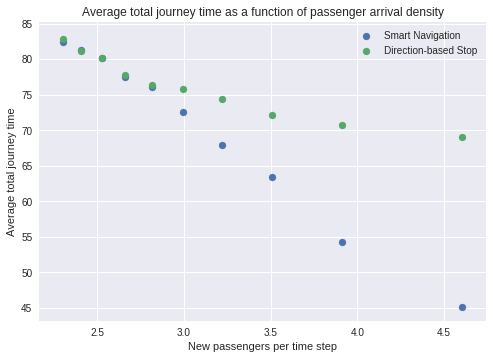

In [0]:
for strat in ["Smart Navigation", "Direction-based Stop"]:
  results[strat] = np.array(results[strat])
  plt.scatter(np.log(1/rates), results[strat],
              label=strat)

plt.xlabel("New passengers per time step")
plt.ylabel("Average total journey time")
plt.title("Average total journey time as a function of passenger arrival density")
plt.legend()
plt.show()

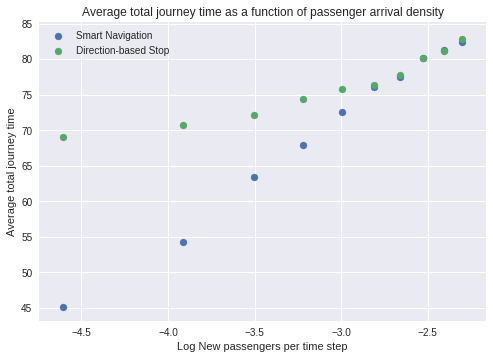

In [0]:
for strat in ["Smart Navigation", "Direction-based Stop"]:
  results[strat] = np.array(results[strat])
  plt.scatter(np.log(rates), results[strat],
              label=strat)

plt.xlabel("Log New passengers per time step")
plt.ylabel("Average total journey time")
plt.title("Average total journey time as a function of passenger arrival density")
plt.legend()
plt.show()